# Databricks ML End-To-End: From Data Ingest, Over Model Creation, To Serving

## Objective: Forecasting the average sales for each month in the upcoming year using AutoML model

Dataset: Retail dataset of a global superstore for 4 years, https://www.kaggle.com/datasets/jr2ngb/superstore-data



## Load data from Catalog


In [0]:
%scala
val superstore_df = spark.table("superstore_forecast")

superstore_df: org.apache.spark.sql.DataFrame = [Row ID: bigint, Order ID: string ... 22 more fields]

## Rename columns to be able to save as Databricks table

It is a good practice to rename column names from having spaces to not having spaces. This approach ensures that the column names are more coding-friendly, reduces the potential for errors, and is generally easier to work with in a variety of data processing tasks

In [0]:
%scala
val superstore = superstore_df.withColumnRenamed("Row ID", "Row_ID")
                .withColumnRenamed("Order ID", "Order_ID")
                .withColumnRenamed("Order Date", "Order_Date")
                .withColumnRenamed("Ship Date", "Ship_Date")
                .withColumnRenamed("Ship Mode", "Ship_Mode")
                .withColumnRenamed("Customer ID", "Customer_ID")
                .withColumnRenamed("Customer Name", "Customer_Name")
                .withColumnRenamed("Postal Code", "Postal_Code")
                .withColumnRenamed("Product ID", "Product_ID")
                .withColumnRenamed("Sub-Category", "Sub_Category")
                .withColumnRenamed("Product Name", "Product_Name")
                .withColumnRenamed("Shipping Cost", "Shipping_Cost")
                .withColumnRenamed("Order Priority", "Order_Priority")


superstore: org.apache.spark.sql.DataFrame = [Row_ID: bigint, Order_ID: string ... 22 more fields]

In [0]:
%scala
// Display schema
superstore.printSchema()

root
-- Row_ID: long (nullable = true)
-- Order_ID: string (nullable = true)
-- Order_Date: string (nullable = true)
-- Ship_Date: string (nullable = true)
-- Ship_Mode: string (nullable = true)
-- Customer_ID: string (nullable = true)
-- Customer_Name: string (nullable = true)
-- Segment: string (nullable = true)
-- City: string (nullable = true)
-- State: string (nullable = true)
-- Country: string (nullable = true)
-- Postal_Code: long (nullable = true)
-- Market: string (nullable = true)
-- Region: string (nullable = true)
-- Product_ID: string (nullable = true)
-- Category: string (nullable = true)
-- Sub_Category: string (nullable = true)
-- Product_Name: string (nullable = true)
-- Sales: double (nullable = true)
-- Quantity: long (nullable = true)
-- Discount: double (nullable = true)
-- Profit: double (nullable = true)
-- Shipping_Cost: double (nullable = true)
-- Order_Priority: string (nullable = true)

In [0]:
%scala
// Display the first five rows
superstore.head(n=5)

res3: Array[org.apache.spark.sql.Row] = Array([42433,AG-2011-2040,1/1/2011,6/1/2011,Standard Class,TB-11280,Toby Braunhardt,Consumer,Constantine,Constantine,Algeria,null,Africa,Africa,OFF-TEN-10000025,Office Supplies,Storage,Tenex Lockers, Blue,408.3,2,0.0,106.14,35.46,Medium], [22253,IN-2011-47883,1/1/2011,8/1/2011,Standard Class,JH-15985,Joseph Holt,Consumer,Wagga Wagga,New South Wales,Australia,null,APAC,Oceania,OFF-SU-10000618,Office Supplies,Supplies,Acme Trimmer, High Speed,120.366,3,0.1,36.036,9.72,Medium], [48883,HU-2011-1220,1/1/2011,5/1/2011,Second Class,AT-735,Annie Thurman,Consumer,Budapest,Budapest,Hungary,null,EMEA,EMEA,OFF-TEN-10001585,Office Supplies,Storage,Tenex Box, Single Width,66.12,4,0.0,29.64,8.17,High], [11731,IT-2011-3647632,1/1/2011,5/1/2011,Second Class,EM-14140,Eugene Moren,Home Office,Stockholm,Stockholm,Sweden,null,EU,North,OFF-PA-10001492,Office Supplies,Paper,Enermax Note Cards, Premium,44.865,3,0.5,-26.055,4.82,High], [22255,IN-2011-47883,1/1/2011,8/1/2011,Standard Class,JH-15985,Joseph Holt,Consumer,Wagga Wagga,New South Wales,Australia,null,APAC,Oceania,FUR-FU-10003447,Furniture,Furnishings,Eldon Light Bulb, Duo Pack,113.67,5,0.1,37.77,4.7,Medium])

## Split in train and holdout set

Use Databricks AutoML in the next step which does its own training/evaluation/test split so the above is mainly to have some data for testing (holdout) the best AutoML model after it has been created on data that the AutoML process has not seen at all yet.

In [0]:
%scala
val Array(training, holdout) = superstore.randomSplit(Array(0.95, 0.05), seed = 12345)

training: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [Row_ID: bigint, Order_ID: string ... 22 more fields]
holdout: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [Row_ID: bigint, Order_ID: string ... 22 more fields]

In [0]:
%scala
println(training.count)
println(holdout.count)

48699
2591

## Write tables to Databricks default DB

Write the Spark dataframes as tables to the Databricks default database to be used for training and testing

In [0]:
%scala
superstore.write.mode("overwrite").format("parquet").saveAsTable("default.superstore_nchs_all")
training.write.mode("overwrite").format("parquet").saveAsTable("default.superstore_nchs_training")
holdout.write.mode("overwrite").format("parquet").saveAsTable("default.superstore_nchs_holdout")

# Create AutoML Forecast Experiment

Instead of writing all the necessary ML code from scratch in a notebook to build a forecasting model, I am going to leverage Databricks’ AutoML capabilities. The AutoML Experiment is easy to configure and will run dozens of trials with different algorithms and in the end produce one winning experiment that I am going to use to build the end-to-end MLOps pipeline.

#### Resume where autogenerated experiment code left off
 

In [0]:
import mlflow
import databricks.automl_runtime

target_col = "Sales" # Target variable
time_col = "Order_Date"
unit = "month"

horizon = 12 # Sets the forecast horizon, which is the number of time units (months) into the future you want to predict.

#### Load training data into PySpark dataframe

Download an artifact from MLflow, read it into a Pandas DataFrame, and then convert it to a PySpark Pandas DataFrame for further processing

In [0]:
import mlflow
import os
import uuid
import shutil
import pandas as pd
import pyspark.pandas as ps

# Create temp directory to download input data from MLflow
input_temp_dir = os.path.join(os.environ["SPARK_LOCAL_DIRS"], "tmp", str(uuid.uuid4())[:8])
os.makedirs(input_temp_dir)

# Download the artifact and read it into a pandas DataFrame
input_data_path = mlflow.artifacts.download_artifacts(run_id="3e9ad12026f44e3f93724301baf0c4bf", artifact_path="data", dst_path=input_temp_dir)

# Reads the downloaded artifact (assumed to be in Parquet format) into a Pandas DataFrame and then converts it to a PySpark Pandas DataFrame
input_file_path = os.path.join(input_data_path, "training_data")
input_file_path = "file://" + input_file_path
df_loaded = ps.from_pandas(pd.read_parquet(input_file_path))

# Preview data
display(df_loaded.head(5))

Order_Date,Sales
2014-02-10T00:00:00Z,13.08
2013-05-03T00:00:00Z,20.76
2013-05-03T00:00:00Z,210.64
2014-03-10T00:00:00Z,60.66
2014-04-07T00:00:00Z,529.32


#### Aggregate data by time_col
Group the data by time_col, and take average if there are multiple target_col values in the same group.

In [0]:
# Calculates the average sales for each unique "Order_Date"

group_cols = [time_col]
df_aggregated = df_loaded \
  .groupby(group_cols) \
  .agg(y=(target_col, "avg")) \
  .reset_index()

display(df_aggregated.head(5))

Order_Date,y
2012-07-11T00:00:00Z,214.84697428571428
2011-10-10T00:00:00Z,225.13822666666664
2014-08-04T00:00:00Z,206.84459090909095
2011-12-04T00:00:00Z,236.07794117647057
2013-07-08T00:00:00Z,190.36520733333333


#### Train Prophet model


In [0]:
import logging

# disable informational messages from prophet
logging.getLogger("py4j").setLevel(logging.WARNING)

In [0]:
result_columns = ["model_json", "mse", "rmse", "mae", "mape", "mdape", "smape", "coverage"]

def prophet_training(history_pd):
  from hyperopt import hp
  from databricks.automl_runtime.forecast.prophet.forecast import ProphetHyperoptEstimator

  seasonality_mode = ["additive", "multiplicative"]
  search_space =  {
    "changepoint_prior_scale": hp.loguniform("changepoint_prior_scale", -6.9, -0.69),
    "seasonality_prior_scale": hp.loguniform("seasonality_prior_scale", -6.9, 2.3),
    "holidays_prior_scale": hp.loguniform("holidays_prior_scale", -6.9, 2.3),
    "seasonality_mode": hp.choice("seasonality_mode", seasonality_mode)
  }
  country_holidays = None
  run_parallel = True
 
  hyperopt_estim = ProphetHyperoptEstimator(horizon=horizon, frequency_unit=unit, metric="smape",interval_width=0.95,
                   country_holidays=country_holidays, search_space=search_space, num_folds=20, max_eval=10, trial_timeout=7028,
                   random_state=367623005, is_parallel=run_parallel)

  spark.conf.set("spark.databricks.mlflow.trackHyperopt.enabled", "false")

  results_pd = hyperopt_estim.fit(history_pd)

  spark.conf.set("spark.databricks.mlflow.trackHyperopt.enabled", "true")
 
  return results_pd[result_columns]

In [0]:
import mlflow
from databricks.automl_runtime.forecast.prophet.model import mlflow_prophet_log_model, ProphetModel

with mlflow.start_run(experiment_id="3770154393612199", run_name="Prophet") as mlflow_run:
  mlflow.set_tag("estimator_name", "Prophet")
  mlflow.log_param("interval_width", 0.95)
  df_aggregated = df_aggregated.rename(columns={time_col: "ds"})

  forecast_results = prophet_training(df_aggregated.to_pandas())
    
  # Log the metrics to mlflow
  metric_name_map = {"mse": "mean_squared_error", "rmse": "root_mean_squared_error", "mae": "mean_absolute_error",
                     "mape": "mean_absolute_percentage_error", "mdape": "mdape", "smape": "smape", "coverage": "coverage"}
  avg_metrics = forecast_results[metric_name_map.keys()].rename(columns=metric_name_map).mean().to_frame(name="mean_metrics").reset_index()
  avg_metrics["index"] = "val_" + avg_metrics["index"].astype(str)
  avg_metrics.set_index("index", inplace=True)
  mlflow.log_metrics(avg_metrics.to_dict()["mean_metrics"])

  # Create mlflow prophet model
  model_json = forecast_results["model_json"].to_list()[0]
  prophet_model = ProphetModel(model_json, horizon, unit, time_col)
  mlflow_prophet_log_model(prophet_model)

/databricks/python/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Because the requested parallelism was None or a non-positive value, parallelism will be set to (4), which is Spark's default parallelism (4), or 1, whichever is greater. We recommend setting parallelism explicitly to a positive value because the total of Spark task slots is subject to cluster sizing.
Hyperopt + MLflow integration is feature-flagged off.  To enable automatic tracking in MLflow, set via: `spark.conf.set('spark.databricks.mlflow.trackHyperopt.enabled', 'true')` where `spark` is your SparkSession.
To view logs from trials, please check the Spark executor logs. To view executor logs, expand 'Spark Jobs' above until you see the (i) icon next to the stage from the trial job. Click it and find the list of tasks. Click the 'stderr' link for a task to view trial logs.


100%|██████████| 10/10 [00:18<00:00,  1.80s/trial, best loss: 0.2699329486125396]

Total Trials: 10: 10 succeeded, 0 failed, 0 cancelled.
08:52:15 - cmdstanpy - INFO - Chain [1] start processing


08:52:15 - cmdstanpy - INFO - Chain [1] done processing
/databricks/python/lib/python3.11/site-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))
/databricks/python/lib/python3.11/site-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

In [0]:
# Show stats of forecast_results. By default we do not display it because the output takes up a lot of storage for large datasets.
forecast_results.describe()

,mse,rmse,mae,mape,mdape,smape,coverage
count,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000
mean,9996.896734,97.55202,66.611219,0.331512,0.200709,0.269933,0.967755
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,9996.896734,97.55202,66.611219,0.331512,0.200709,0.269933,0.967755
25%,9996.896734,97.55202,66.611219,0.331512,0.200709,0.269933,0.967755
50%,9996.896734,97.55202,66.611219,0.331512,0.200709,0.269933,0.967755
75%,9996.896734,97.55202,66.611219,0.331512,0.200709,0.269933,0.967755
max,9996.896734,97.55202,66.611219,0.331512,0.200709,0.269933,0.967755


#### Analyze the predicted results

In [0]:
# Load the model
run_id = mlflow_run.info.run_id
loaded_model = mlflow.pyfunc.load_model(f"runs:/{run_id}/model")

In [0]:
# Set up the future dates for which the model will make predictions

future_df = loaded_model._model_impl.python_model.make_future_dataframe()
display(future_df.head(5))

/databricks/python/lib/python3.11/site-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))


ds
2011-01-01T00:00:00Z
2011-01-02T00:00:00Z
2011-01-03T00:00:00Z
2011-01-04T00:00:00Z
2011-01-06T00:00:00Z


In [0]:
# Predict future with the default horizon
forecast_pd = loaded_model._model_impl.python_model.model().predict(future_df)

/databricks/python/lib/python3.11/site-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))


In [0]:
# Plotly plots is turned off by default because it takes up a lot of storage.
# Set this flag to True and re-run the notebook to see the interactive plots with plotly
use_plotly = False

In [0]:
# Get prophet model
model = loaded_model._model_impl.python_model.model()
predict_pd = forecast_pd

/databricks/python/lib/python3.11/site-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))


#### Plot the forecast with change points and trend
Plot the forecast using the plot method with your forecast dataframe. You can use prophet.plot.add_changepoints_to_plot to overlay significant changepoints. An interactive figure can be created with plotly.

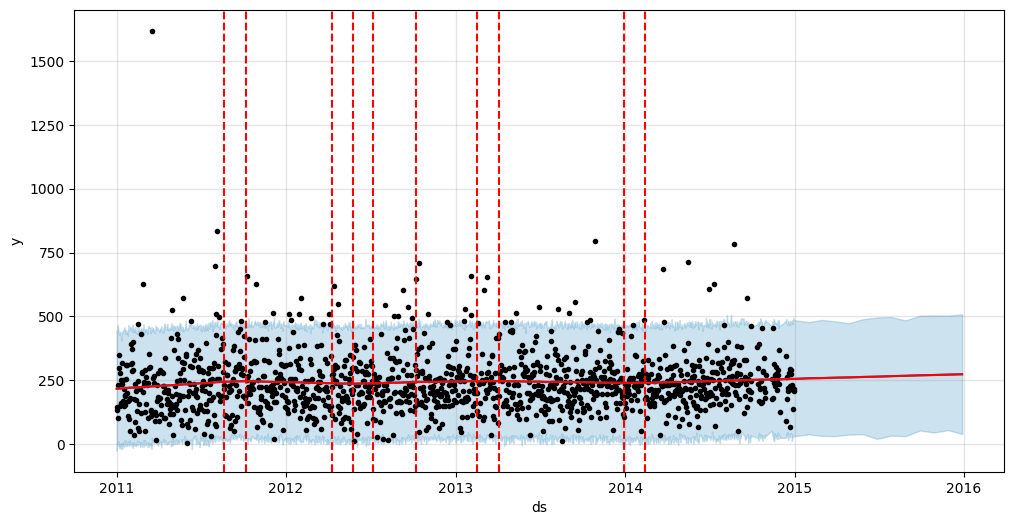

In [0]:
from prophet.plot import add_changepoints_to_plot, plot_plotly
import matplotlib.pyplot as plt

if use_plotly:
    fig = plot_plotly(model, predict_pd, changepoints=True, trend=True, figsize=(1200, 600))
    fig.show()
else:
    fig, ax = plt.subplots(figsize=(12, 6))
    model.plot(predict_pd, ax=ax)
    add_changepoints_to_plot(ax, model, predict_pd)
    plt.show()

#### Plot the forecast components
Use the Prophet.plot_components method to see the components. By default you'll see the trend, yearly seasonality, and weekly seasonality of the time series. You can also include holidays. An interactive figure can be created with plotly.

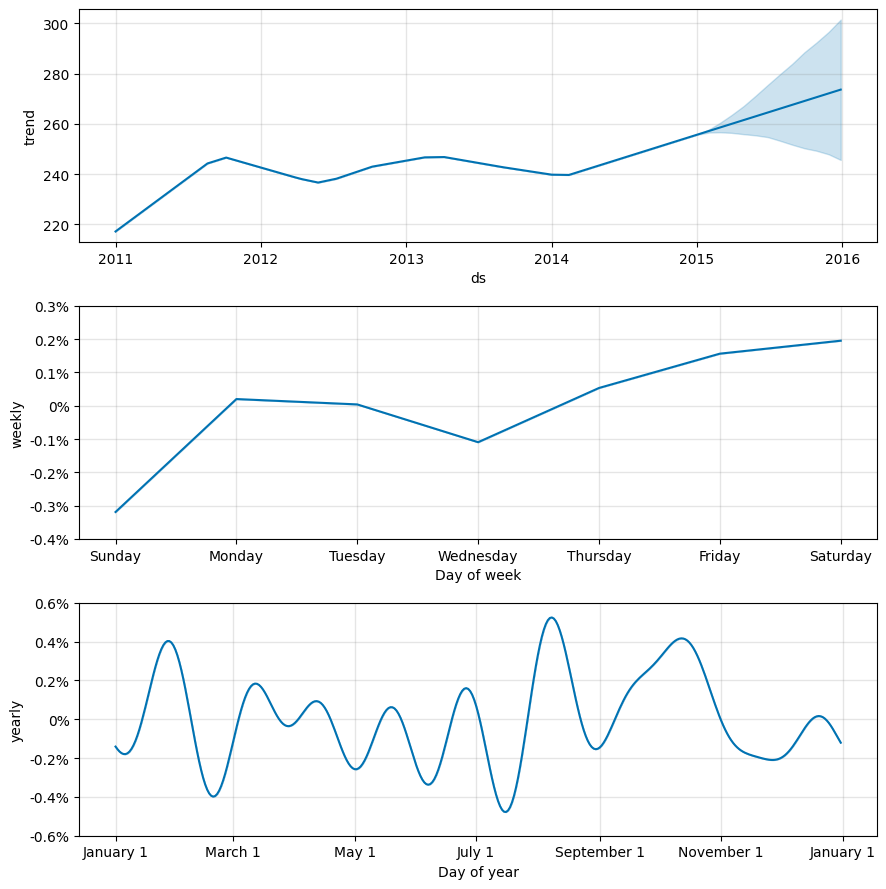

In [0]:
from prophet.plot import plot_components_plotly

if use_plotly:
    fig = plot_components_plotly(model, predict_pd, figsize=(900, 400))
    fig.show()
else:
    fig = model.plot_components(predict_pd)

#### Show the predicted results

In [0]:
predict_cols = ["ds", "yhat"]
forecast_pd = forecast_pd.reset_index()
display(forecast_pd[predict_cols].tail(horizon))

ds,yhat
2015-01-31T00:00:00Z,258.60838292798115
2015-02-28T00:00:00Z,258.5807861992352
2015-03-28T00:00:00Z,260.3615985990972
2015-04-28T00:00:00Z,260.9181166511346
2015-05-28T00:00:00Z,262.87413798680655
2015-06-28T00:00:00Z,264.07484022267204
2015-07-28T00:00:00Z,266.1449551457462
2015-08-28T00:00:00Z,267.60651333243413
2015-09-28T00:00:00Z,269.89029678886203
2015-10-28T00:00:00Z,270.61377083432563


# Build End-To-End MLOps Workflow From Data Ingest To Model Deployment
Reuse the auto-generated model code from the best AutoML trial and enhance it with data ingest and model deployment code so the resulting notebook here can be run from start to finish and that way each time pull fresh data from the catalog, save it to the Databricks default database, train an Prophet model with the best hyperparameters from the top AutoML run, do batch inference on the holdout dataset, and in case the batch predictions are better than the 90 percent success threshold, automatically deploy the model into the Databricks Model Registry so it can be used either for batch predictions or real-time model serving via a REST API interface.


#### Register model after training

In [0]:
import mlflow

model_uri = f"runs:/{mlflow_run.info.run_id}/model"

# Register the model with MLflow
registered_model_version = mlflow.register_model(model_uri, "ProphetModel")

# Print the registered model URI
print(f"Model registered under URI: {model_uri}")
print(f"Registered model version: {registered_model_version.version}")


Registered model 'ProphetModel' already exists. Creating a new version of this model...
2024/08/21 06:35:40 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: ProphetModel, version 4


Model registered under URI: runs:/68f5705bf5f841a3a33093ef43952ff1/model
Registered model version: 4


Created version '4' of model 'ProphetModel'.


#### Setting the model stage as Staging

If you're still testing or validating the model, you might want to set it to "Staging"

When the model is ready for deployment and use in a live environment, transition it to "Production"

In [0]:
from mlflow.tracking import MlflowClient

# Initialize the MLflow Client
client = MlflowClient()

# Transition the registered model version to the "Staging" stage
client.transition_model_version_stage(
    name="ProphetModel",  # The name of the registered model
    version=registered_model_version.version,  # The version number of the model
    stage="Staging"  # The stage to transition to ("Staging", "Production", or "Archived")
)

print(f"Model version {registered_model_version.version} set to 'Staging' stage.")


/root/.ipykernel/22163/command-2495303028643627-3256157027:7: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.13.1/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


Model version 4 set to 'Staging' stage.


#### Define input and output for batch inference

The table path assigned to input_table_name will be used for batch inference and the predictions will be saved to output_table_path.

In [0]:
# redefining key variables here because %pip and %conda restarts the Python interpreter
input_table_name = "default.superstore_nchs_holdout" # Test the best AutoML model with holdout set
output_table_path = "/FileStore/batch-inference/superstore_nchs"

In [0]:
# load table as a Spark DataFrame
table = spark.table(input_table_name)

#### Load model and run inference

If the new model achieves the success criteria, register it into the MLFlow

A MAPE under 10% shows high accuracy, 10-20% shows good forecast results, 20-50% shows reasonable forecast results, and greater than 50% shows incorrect results 

In [0]:
import mlflow
from databricks.automl_runtime.forecast.prophet.model import mlflow_prophet_log_model, ProphetModel

# Define a success threshold for MAPE (e.g., MAPE < 20%)
success_threshold = 0.20

with mlflow.start_run(experiment_id="3770154393612199", run_name="Prophet") as mlflow_run:
    mlflow.set_tag("estimator_name", "Prophet")
    mlflow.log_param("interval_width", 0.95)
    df_aggregated = df_aggregated.rename(columns={time_col: "ds"})

    # Train the model and get forecast results
    forecast_results = prophet_training(df_aggregated.to_pandas())

    # Log the metrics to mlflow
    metric_name_map = {
        "mse": "mean_squared_error",
        "rmse": "root_mean_squared_error",
        "mae": "mean_absolute_error",
        "mape": "mean_absolute_percentage_error",
        "mdape": "mdape",
        "smape": "smape",
        "coverage": "coverage"
    }
    avg_metrics = forecast_results[metric_name_map.keys()] \
        .rename(columns=metric_name_map) \
        .mean() \
        .to_frame(name="mean_metrics") \
        .reset_index()
    
    avg_metrics["index"] = "val_" + avg_metrics["index"].astype(str)
    avg_metrics.set_index("index", inplace=True)
    
    # Log the calculated metrics to MLflow
    mlflow.log_metrics(avg_metrics.to_dict()["mean_metrics"])

    # Retrieve the MAPE value to check against the success threshold
    mape_value = avg_metrics.loc["val_mean_absolute_percentage_error", "mean_metrics"]

    # Check if the model meets the success criteria
    if mape_value < success_threshold:
        print(f"Model meets the success criteria with MAPE: {mape_value}. Registering the model...")
        
        # Create and log the MLflow Prophet model
        model_json = forecast_results["model_json"].to_list()[0]
        prophet_model = ProphetModel(model_json, horizon, unit, time_col)
        mlflow_prophet_log_model(prophet_model)
        
        # Register the model
        registered_model_version = mlflow.register_model(f"runs:/{mlflow_run.info.run_id}/model", "ProphetModel")
    else:
        print(f"Model did not meet the success threshold. MAPE: {mape_value}. Registration skipped.")



Because the requested parallelism was None or a non-positive value, parallelism will be set to (4), which is Spark's default parallelism (4), or 1, whichever is greater. We recommend setting parallelism explicitly to a positive value because the total of Spark task slots is subject to cluster sizing.
Hyperopt + MLflow integration is feature-flagged off.  To enable automatic tracking in MLflow, set via: `spark.conf.set('spark.databricks.mlflow.trackHyperopt.enabled', 'true')` where `spark` is your SparkSession.
To view logs from trials, please check the Spark executor logs. To view executor logs, expand 'Spark Jobs' above until you see the (i) icon next to the stage from the trial job. Click it and find the list of tasks. Click the 'stderr' link for a task to view trial logs.


100%|██████████| 10/10 [00:14<00:00,  1.40s/trial, best loss: 0.2699329486125396]


Total Trials: 10: 10 succeeded, 0 failed, 0 cancelled.
06:36:05 - cmdstanpy - INFO - Chain [1] start processing
06:36:05 - cmdstanpy - INFO - Chain [1] done processing


Model did not meet the success threshold. MAPE: 0.3315119149434439. Registration skipped.


#### Update the production model in MLflow Model Registry

If the model meets the success criteria, archived the existing model and update the new model to production stage

In [0]:
if mape_value < success_threshold:
    try:
        client.transition_model_version_stage(
              name="ProphetModel",
              version=int(registered_model_version.version)-1,
              stage="Archived"
            )
    except Exception as e:
        print(f"Error archiving previous model versions: {e}")
    
    try:
        client.transition_model_version_stage(
              name="ProphetModel",
              version=registered_model_version.version,
              stage="Production",
              archive_existing_versions=True
            )
    except Exception as e:
        print(f"Error transitioning model to Production: {e}")


# Schedule MLOps Pipeline And Make Real-Time Predictions

To make this an automated, repeatable process that will build and deploy a new model on fresh data in case the catalog updates the source dataset and the new model surpasses the set threshold of 90 percent correct predictions on the new holdout dataset, all that needs to be done is to schedule a Databricks Workflow which can be achieved on the notebook page view by clicking on ‘Schedule’